In [1]:
import json
import sys
import random
from tqdm import tqdm
from collections import defaultdict
import pyarrow as pa
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer, util
import torch

# Import data

In [2]:
%%time
root = '.'

train_data = list(
    map(json.loads, open(f"{root}/cosmos/train_data.json").readlines())
)
test_data = list(
    map(json.loads, open(f"{root}/cosmos/test_data.json").readlines())
)
#train_data = list(map(json.loads, open(f"{root}/cosmos/val_data.json").readlines()))

CPU times: user 9.94 s, sys: 534 ms, total: 10.5 s
Wall time: 10.6 s


# Remove duplicate captions

In [3]:
len(train_data)

161754

In [4]:
train_data_full = list(
    map(json.loads, open(f"{root}/cosmos/val_data.json").readlines())
)

In [5]:
def remove_duplicate(dataset):
    for data in tqdm(dataset):
        seen_caption = set()
        new_list = []
        for caption in data['articles'][:1]:
            if caption['caption_modified'] not in seen_caption:
                new_list.append(caption)
                seen_caption.add(caption['caption_modified'])
        if len(new_list)==0:
            print('0',end='')
        data['articles'] = new_list
    return seen_caption
# train_data_full = train_data.copy()
remove_duplicate(train_data)

100%|██████████| 41006/41006 [00:00<00:00, 453186.77it/s]


{'PERSON, ORG cars are seen above the city of FAC.'}

# SBERT Paraphrase Mining

In [6]:
model = SentenceTransformer('stsb-bert-base')

In [34]:
def neg_cos_sim(a, b):
    """
    Computes the cosine similarity cos_sim(a[i], b[j]) for all i and j.
    :return: Matrix with res[i][j]  = cos_sim(a[i], b[j])
    """
    if not isinstance(a, torch.Tensor):
        a = torch.tensor(a)

    if not isinstance(b, torch.Tensor):
        b = torch.tensor(b)

    if len(a.shape) == 1:
        a = a.unsqueeze(0)

    if len(b.shape) == 1:
        b = b.unsqueeze(0)

    a_norm = torch.nn.functional.normalize(a, p=2, dim=1)
    b_norm = torch.nn.functional.normalize(b, p=2, dim=1)
    return torch.neg(torch.mm(a_norm, b_norm.transpose(0, 1)))

In [7]:
# Single list of sentences - Possible tens of thousands of sentences
sentences = []

for data in tqdm(train_data):
    for caption in data['articles']:
        sentences.append(caption['caption_modified'])

100%|██████████| 41006/41006 [00:00<00:00, 912253.06it/s]


In [8]:
# paraphrases = util.paraphrase_mining(model, sentences, top_k=1, score_function=neg_cos_sim)
paraphrases = util.paraphrase_mining(model, sentences, top_k=1,show_progress_bar=True,
batch_size=64)

Batches:   0%|          | 0/641 [00:00<?, ?it/s]

In [9]:
print(len(sentences))
print(len(paraphrases))

41006
35000


In [10]:
closet = [(g[1],g[2]) for g in paraphrases if g[0]<0.7 and g[0]>0.65]
len(closet)

6768

In [11]:
sentence_dict = {}
for z in closet:
    key = sentences[z[0]]
    sentence_dict[key] = sentences[z[1]]

In [153]:
# furthest_list = np.empty((len(sentences),),dtype=int)
# for entry in paraphrases:
#     furthest_list[entry[1]]=entry[2]
# sentences_dict = dict()
# for x in range(len(sentences)):
#     sentences_dict[sentences[x]] = x

# Gen case functions

In [12]:
f = open('/root/thesis/X-VLM/image_cap_dict.json')

image_cap_dict = json.load(f)
f.close()

In [24]:
def gen_caption(data):
    cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
    try:
        cap2 = image_cap_dict[data['img_local_path']]
        return [data['img_local_path'],[cap1],[cap2],[False]]
    except:
        return None

In [13]:
# Take 2 random correct caption
def gen_positive_case(data):
    caption_1_idx, caption_2_idx = random.sample(range(0,len(data['articles'])),2)
    cap1 = data['articles'][caption_1_idx]['caption_modified']
    cap2 = data['articles'][caption_2_idx]['caption_modified']
    if cap1 == cap2:
        return None
    return [data['img_local_path'],[cap1],[cap2],[False]]

In [4]:
# Take 2 random false caption
def gen_negative_case_1(data, train_data):
    data_random1 = train_data[np.random.randint(len(train_data))]
    while data['img_local_path'] == data_random1['img_local_path']:
        data_random1 = train_data[np.random.randint(len(train_data))]
    cap1 = data_random1['articles'][np.random.randint(len(data_random1['articles']))]['caption_modified']
    data_random2 = train_data[np.random.randint(len(train_data))]
    while data['img_local_path'] == data_random2['img_local_path']:
        data_random2 = train_data[np.random.randint(len(train_data))]
    cap2 = data_random2['articles'][np.random.randint(len(data_random2['articles']))]['caption_modified']
    return [data['img_local_path'],[cap1],[cap2],[True]]

In [5]:
# Take 1 random correct caption, 1 random false caption
def gen_negative_case_2(data, train_data):
     # Pick 1st correct caption
    if np.random.rand()>0.5:
        cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
        # Pick a random article then pick its first caption
        data_random = train_data[np.random.randint(len(train_data))]
        while data['img_local_path'] == data_random['img_local_path']:
            data_random = train_data[np.random.randint(len(train_data))]
        cap2 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
    else:
        cap2 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
        # Pick a random article then pick its first caption
        data_random = train_data[np.random.randint(len(train_data))]
        while data['img_local_path'] == data_random['img_local_path']:
            data_random = train_data[np.random.randint(len(train_data))]
        cap1 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
    return [data['img_local_path'],[cap1],[cap2],[True]]

In [14]:
def gen_closest(data, sentences_dict):
    cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
    try:
        cap2 = sentences_dict[cap1]
        return [data['img_local_path'],[cap1],[cap2],[True]]
    except:
        return None

In [15]:
def gen_hoax(data, sufix=' wasn\'t true.'):
    cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
    cap2 = cap1.rstrip('.') + sufix
    return [data['img_local_path'],[cap1],[cap2],[True]]


In [15]:
def gen_negative_case_3(data, train_data, furthest_list, sentences_dict, sentences, count):
    # pick 1 random correct caption
    cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
    # then find its furthest distance caption
    cap1_index = sentences_dict[cap1]
    try:
        cap2 = sentences[furthest_list[cap1_index]]
    except:
        data_random = train_data[np.random.randint(len(train_data))]
        while data['img_local_path'] == data_random['img_local_path']:
            data_random = train_data[np.random.randint(len(train_data))]
        cap2 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
        count.append(cap1_index)
    return [data['img_local_path'],[cap1],[cap2],[True]]

In [16]:
def gen_negative_case_4(data,train_data, furthest_list, sentences_dict, sentences, count):
    # pick 1 random false caption
    data_random = train_data[np.random.randint(len(train_data))]
    while data['img_local_path'] == data_random['img_local_path']:
        data_random = train_data[np.random.randint(len(train_data))]
    cap1 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
    # then find its furthest distance caption
    cap1_index = sentences_dict[cap1]
    try:
        cap2 = sentences[furthest_list[cap1_index]]
    except:
        data_random = train_data[np.random.randint(len(train_data))]
        while data['img_local_path'] == data_random['img_local_path']:
            data_random = train_data[np.random.randint(len(train_data))]
        cap2 = data_random['articles'][np.random.randint(len(data_random['articles']))]['caption_modified']
        count.append(cap1_index)
    return [data['img_local_path'],[cap1],[cap2],[True]]

In [32]:
def gen_negative_case_5(data, train_data):
      # choose random image
    result = gen_positive_case(data)
    if result is not None:
      result[0] = train_data[np.random.randint(len(train_data))]['img_local_path']
    return result


In [9]:
def gen_negative_case_6(data, train_data):
      # choose random image
    result = gen_positive_case(data)
    if result is not None:
      result[0] = train_data[np.random.randint(len(train_data))]['img_local_path']
    return result

In [16]:
from SentenceNegator import SentenceNegator
sn = SentenceNegator()

def gen_negative_sentence(data):
    cap1 = data['articles'][np.random.randint(len(data['articles']))]['caption_modified']
    cap2 = sn.negate(cap1)
    if cap2 != cap1:
        return [data['img_local_path'],[cap1],[cap2],[True]]
    else:
        return None

In [17]:
np.random.seed(42)
train_data_sample = np.random.choice(train_data_full, size=int(len(train_data_full)*50/100))
# Not OOC cases
l = []
correct = 0
hoax=0
cap=0
closet=0
neg=0
for data in tqdm(train_data_sample):
     if len(data['articles']) > 1:
          r = gen_positive_case(data)
          if r is not None:
               l.append(r)
               correct+=1

     if np.random.rand()>0.7:
          r = gen_negative_sentence(data)
          if r is not None:
               l.append(r)
               neg+=1
    
     if np.random.rand()>0.7:
          r = gen_hoax(data)
          if np.random.rand()>0.5:
               r = gen_hoax(data, ' was fake.')
          l.append(r)
          hoax+=1
     
     # r = gen_caption(data)
     # if r is not None:
     #      l.append(r)
     #      cap+=1

     r = gen_closest(data,sentence_dict)
     if r is not None:
          l.append(r)
          closet+=1

100%|██████████| 20503/20503 [00:00<00:00, 55137.82it/s]


<AxesSubplot:ylabel='count'>

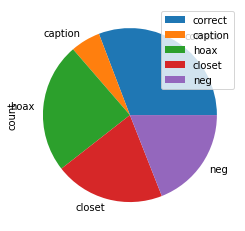

In [43]:
pd.DataFrame({'count': [correct,cap,hoax,closet,neg]},
index=['correct','caption','hoax','closet','neg']).plot.pie(y='count')

<AxesSubplot:ylabel='count'>

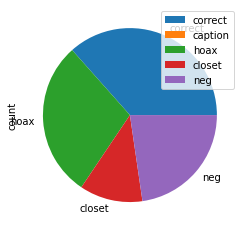

In [18]:
pd.DataFrame({'count': [correct,cap,hoax,closet,neg]},
index=['correct','caption','hoax','closet','neg']).plot.pie(y='count')

In [19]:
dataframe = pd.DataFrame(
    l, columns=["image", "caption_1", "caption_2", "label"],
)

In [20]:
dataframe_xvlm = pd.DataFrame(
    l, columns=["img_local_path", "caption1", "caption2", "context_label"],
)

In [21]:
with open("/root/thesis/X-VLM/data/finetune/cosmos_val.json", "w") as outfile:
    outfile.write(json.dumps(dataframe_xvlm.to_dict(orient='records'))
)

In [22]:
dataframe[0:20]

,image,caption_1,caption_2,label
0,val/15795.jpg,[FAC in GPE is one of ORG CARDINAL projects in...,[FAC in GPE is one of ORG Group&#39;s five pro...,[False]
1,val/15795.jpg,[FAC in GPE is one of ORG Group&#39;s five pro...,[FAC in GPE is one of ORG Group&#39;s five pro...,[True]
2,val/860.jpg,"[President PERSON will travel to GPE, GPE, on ...","[President PERSON will travel to GPE, GPE, on ...",[True]
3,val/860.jpg,"[President PERSON will travel to GPE, GPE, on ...",[Gov. PERSON delivered his final State of the ...,[True]
4,val/38161.jpg,[Ilkay Gundogan scores the ORDINAL goal for GP...,[DATE: Ilkay Gundogan scores the ORDINAL goal ...,[False]
5,val/38161.jpg,[Ilkay Gundogan scores the ORDINAL goal for GP...,[Ilkay Gundogan scores the ORDINAL goal for GP...,[True]
6,val/11284.jpg,[PERSON Music Initiative performs at FAC],[PERSON Music Initiative does not perform at FAC],[True]
7,val/16850.jpg,[ORG came to GPE to purchase CARDINAL of pairs...,[GPE Ladies High Boots Low-kole CARDINAL GPE b...,[True]
8,val/37197.jpg,"[In DATE, she played PERSON at FAC opposite PE...",[PERSON and PERSON in a DATE production at the...,[False]
9,val/37197.jpg,"[In DATE, she played PERSON at FAC opposite PE...","[In DATE, she played PERSON at FAC opposite PE...",[True]


In [23]:
def load_image(path):
   try:
      with open(path, "rb") as fp:
        return fp.read()
   except:
      return None

In [24]:
tqdm.pandas()

dataframe['image'] = dataframe['image'].progress_apply(lambda x: load_image(x))

/root/anaconda3/envs/vilt/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 21386/21386 [00:07<00:00, 2949.97it/s]


# PyArrow

In [25]:
table = pa.Table.from_pandas(dataframe)


In [26]:
split = 'val'
with pa.OSFile(f"dataset/close/cosmos_{split}.arrow", "wb") as sink:
    with pa.RecordBatchFileWriter(sink, table.schema) as writer:
        writer.write_table(table)
# Data 2 mất file train

# Val

# Test

In [9]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [10]:
def modify_caption_replace_entities(caption_text):
    """
        Utility function to replace named entities in the caption with their corresponding hypernyms
        Args:
            caption_text (str): Original caption with named entities
        Returns:
            caption_modified (str): Modified caption after replacing named entities
    """
    doc = nlp(caption_text)
    caption_modified = caption_text
    caption_entity_list = []
    for ent in doc.ents:
        caption_entity_list.append((ent.text, ent.label_))
        caption_modified = caption_modified.replace(ent.text, ent.label_, 1)
    return caption_modified

In [11]:
l_test  = []
for data in tqdm(test_data):
    cap1 = modify_caption_replace_entities(data['caption1'])
    cap2 = modify_caption_replace_entities(data['caption2'])
    l_test.append([data['img_local_path'],[cap1],[cap2],[data['context_label']==True]])

100%|██████████| 1700/1700 [00:24<00:00, 69.59it/s]


In [25]:
dataframe_test = pd.DataFrame(
    l_test, columns=["img_local_path", "caption1", "caption2", "context_label"],
)


In [26]:
# json.dumps(dataframe_test.to_dict(orient='records'))
#.to_json('test.json', orient='records', lines=True)
with open("test.json", "w") as outfile:
    outfile.write(json.dumps(dataframe_test.to_dict(orient='records'))
)

In [74]:
dataframe_test

,image,caption_1,caption_2,label
0,test/0.jpg,"[PERSON at his announcement in GPE, GPE, on DA...","[PERSON at his announcement in GPE, GPE, on DA...",[False]
1,test/1.jpg,[Supporters of GPE's ruling ORG party come out...,[A person sits on a truck as supporters of the...,[False]
2,test/2.jpg,[CARDINAL dead people turned up on the state’s...,[These social media posts did not link to a re...,[True]
3,test/3.jpg,"[Actor, musician, director and devoted followe...",[A shocking report about the former child acto...,[True]
4,test/4.jpg,[Men from the LOC tribe perform a traditional ...,"[And on DATE in GPE's Narok county, young PERS...",[False]
...,...,...,...,...
1695,test/1695.jpg,[President PERSON trademarked the name 'WORK_O...,[There was no truth that PERSON family MONEY w...,[True]
1696,test/1696.jpg,[A photograph shows a soldier carrying a donke...,[Coronavirus meme featuring “EVENT donkey” is ...,[True]
1697,test/1697.jpg,[Homeless people living on streets in GPE],[ORG in GPE],[False]
1698,test/1698.jpg,[The castle's esplanade was a perfect spot for...,[Picture shows an ORG skier],[False]


In [75]:
tqdm.pandas()

dataframe_test['image'] = dataframe_test['image'].progress_apply(lambda x: load_image(x))

/root/anaconda3/envs/vilt/lib/python3.8/site-packages/tqdm/std.py:702: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel
100%|██████████| 1700/1700 [00:00<00:00, 9703.16it/s]


In [76]:
dataframe_test

,image,caption_1,caption_2,label
0,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[PERSON at his announcement in GPE, GPE, on DA...","[PERSON at his announcement in GPE, GPE, on DA...",[False]
1,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Supporters of GPE's ruling ORG party come out...,[A person sits on a truck as supporters of the...,[False]
2,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[CARDINAL dead people turned up on the state’s...,[These social media posts did not link to a re...,[True]
3,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,"[Actor, musician, director and devoted followe...",[A shocking report about the former child acto...,[True]
4,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Men from the LOC tribe perform a traditional ...,"[And on DATE in GPE's Narok county, young PERS...",[False]
...,...,...,...,...
1695,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[President PERSON trademarked the name 'WORK_O...,[There was no truth that PERSON family MONEY w...,[True]
1696,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[A photograph shows a soldier carrying a donke...,[Coronavirus meme featuring “EVENT donkey” is ...,[True]
1697,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[Homeless people living on streets in GPE],[ORG in GPE],[False]
1698,b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00...,[The castle's esplanade was a perfect spot for...,[Picture shows an ORG skier],[False]


# PyArrow

In [77]:
table = pa.Table.from_pandas(dataframe_test)
split = 'test'
with pa.OSFile(f"dataset_50/cosmos_{split}.arrow", "wb") as sink:
    with pa.RecordBatchFileWriter(sink, table.schema) as writer:
        writer.write_table(table)